In [209]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import ast
import numpy as np

In [210]:
file_path = '../data/listings.csv.gz'

with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        listings = pd.read_csv(file)

### id and listing_url

###### The id corresponds to the last part of the url. We therefore remove the url as a feature because it does not add addtional value.

In [211]:
listings = listings.drop('listing_url', axis=1)

### scrape_id, last_scraped and source

###### The scrape_id is the same for each row. We remove this variable as well. Last_scraped and source are also removed.

In [212]:
listings = listings.drop('scrape_id', axis=1)
listings = listings.drop('last_scraped', axis=1)
listings = listings.drop('source', axis=1)

### description

###### Description consists of plain text. No pattern.

In [213]:
# Want to check if many words are written in multiple descriptions.
common_words = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "I",
    "it", "for", "not", "on", "with", "he", "as", "you", "do", "at",
    "this", "but", "his", "by", "from", "they", "we", "say", "her", "she",
    "or", "an", "will", "my", "one", "all", "would", "there", "their", "what",
    "so", "up", "out", "if", "about", "who", "get", "which", "go", "me",
    "when", "make", "can", "like", "time", "no", "just", "him", "know", "take",
    "people", "into", "year", "your", "good", "some", "could", "them", "see", "other",
    "than", "then", "now", "look", "only", "come", "its", "over", "think", "also",
    "back", "after", "use", "two", "how", "our", "work", "first", "well", "way",
    "even", "new", "want", "because", "any", "these", "give", "day", "most", "us", "is", "/><br",
    "<br", "space</b><br", "/><b>The", "are", "The", "has", "living", "2", "/>The", "room", "located",
    "/>", "This", "private", "&", '/><b>Guest', 'space', 'access</b><br', 'access', '/>-', 'full', '1', 
    'floor', 'home', 'away', 'bed', 'bathroom', 'New', '-', 'minutes', 'place', 'large', '/>This', 'bedroom',
    'walk', 'size', 'great', 'things', 'very', 'comfortable', 'spacious', 'building', '3', '/><b>Other', 
    'note</b><br', 'We', 'fully', 'stay', 'York', 'bed,', 'A', 'available', 'Brooklyn', 'close', 'area', 
    'beautiful', 'blocks', 'perfect', 'min', 'There', 'queen', 'Central', 'NYC', 'room,', 'need', 'You', 
    'block', 'neighborhood', 'dining', 'everything', 'It', 'East', 'enjoy', 'best', '5', 'walking', 'Park',
    'studio', 'guests', 'minute', 'within', '/>You', 'street', 'coffee', 'clean', 'location', 'own', 'features', 
    '/><b>During', 'amenities', 'city', 'stay</b><br', 'TV', '4', 'distance', 'free', 'house', 'easy', 'right', 
    'unit', 'Park,', 'near', '/>•', 'high', 'guest', 'offers', 'Times', 'including', 'few', '10', 'bedrooms', 
    'many', 'Located', 'love', 'steps', 'Enjoy', 'entire', 'feel'
]

# Tokenizing the strings in the 'description' column
words = listings['description'].str.split(expand=True).stack()

# Counting the frequency of each word
word_counts = words.value_counts()

# Dropping common words from the counts
word_counts = word_counts.drop(labels=common_words, errors='ignore')

# Transforming all letters to lowercase and removing everything that is not characters
word_counts.index = word_counts.index.str.lower().str.replace(r'[^a-z]', '', regex=True)

# Optional: Recounting the frequency after transformations (since some words might become identical after the transformation)
word_counts = word_counts.groupby(level=0).sum().sort_values(ascending=False)

# Filtering words with counts above a threshold (10000 in this case)
frequent_words = word_counts[word_counts > 1000]

print(frequent_words)


# Converting the frequent words to a list
frequent_words_list = frequent_words.index.tolist()

print(frequent_words_list)

                    64863
apartment           42924
kitchen             25511
manhattan           12126
restaurants         11571
subway               9721
train                9058
bedroom              8080
quiet                7743
bathroom             7169
youll                7128
furnished            7094
heart                7060
modern               6935
wifi                 6838
cozy                 6737
square               6593
building             6487
shared               6450
equipped             6415
city                 6378
room                 6285
please               6274
br                   6108
renovated            5965
its                  5727
bars                 5656
tv                   5486
station              5000
center               4986
home                 4979
space                4966
light                4856
closet               4808
th                   4676
windows              4600
laundry              4508
desk                 4445
no          

In [214]:
important_words = ['apartment', 'kitchen', 'manhattan', 'subway', 'train', 'quiet', 'furnished', 'heart', 'modern', 'wifi', 'cozy', 
 'renovated', 'laundry', 'desk', 'park', 'shop', 'luxury', 'safe', 'elevator', 'garden', 'parking', 'stylish', 'furniture', 
 'village', 'downtown', 'backyard', 'bus', 'transportation', 'museum', 'peaceful', 'rooftop', 'cafe', 'dishwasher', 'airport', 'netflix', 
 'balcony', 'grocery', 'refrigerator', 'comfy', 'fridge', 'doorman', 'comfortably', 'terrace', 'bar', 'oven', 'store', 'restaurant', 
 'old', 'supermarket']

In [215]:
# Convert to lowercase and remove non-letter characters
listings['description'] = listings['description'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

# Make new a new boolean column for each word
for word in important_words:
    column_name = "is_" + word
    listings[column_name] = listings['description'].fillna('').str.contains(word, case=False, regex=False).astype(int)

# Merge cozy, comfy and comfortably columns
# Create the new 'is_comfy' column by checking if at least one of the columns has a value of 1 for each row
listings['is_comfortable'] = listings[['is_cozy', 'is_comfy', 'is_comfortably']].max(axis=1)
listings = listings.drop(columns=['is_cozy', 'is_comfy', 'is_comfortably'])

# Merge quiet and peaceful
listings['is_quiet'] = ((listings['is_quiet'] == 1) | (listings['is_peaceful'] == 1)).astype(int)
listings.drop('is_peaceful', axis=1, inplace=True)

# Merge furnished and furniture
listings['is_furnished'] = ((listings['is_furnished'] == 1) | (listings['is_furniture'] == 1)).astype(int)
listings.drop('is_furniture', axis=1, inplace=True)

# Merge refrigerator and fridge
listings['is_fridge'] = ((listings['is_fridge'] == 1) | (listings['is_refrigerator'] == 1)).astype(int)
listings.drop('is_refrigerator', axis=1, inplace=True)

# Merge balcony and terrace
listings['is_balcony'] = ((listings['is_balcony'] == 1) | (listings['is_terrace'] == 1)).astype(int)
listings.drop('is_terrace', axis=1, inplace=True)

# Merge shop and store
listings['is_shop'] = ((listings['is_shop'] == 1) | (listings['is_store'] == 1)).astype(int)
listings.drop('is_store', axis=1, inplace=True)

# Merge grocery and supermarket
listings['is_supermarket'] = ((listings['is_supermarket'] == 1) | (listings['is_grocery'] == 1)).astype(int)
listings.drop('is_grocery', axis=1, inplace=True)

In [216]:
# Drop description
listings.drop('description', axis=1, inplace=True)

### neighborhood_overview

###### neighborhood_overview is a description of the neighborhood in plain text. No pattern. We romove this column, but could do something similar as for description.

In [217]:
listings = listings.drop('neighborhood_overview', axis=1)

### picture_url

###### picture_url is irrelevant and can be dropped

In [218]:
listings = listings.drop('picture_url', axis=1)

### host_id, host_url and host_name

###### host_id is a unique identifier of the host. The id corresponds to the last part of the host_url. We therefore remove the url as a feature. host_name is not a unique identifier. We romove this.

In [219]:
listings = listings.drop('host_url', axis=1)
listings = listings.drop('host_name', axis=1)

### host_since

###### host_since is a string on the form yyyy-mm-dd. Five NaN-values.

In [220]:
pd.set_option('display.max_columns', None)
nan_rows = listings[listings['host_since'].isna()]

In [221]:
# All the rows where the host_since column is NaN, it seems like the data are wrong, not only for the host, 
# but also for the availability column. We therefore remove all these rows.

# Remove rows with NaN values in the 'host_since' column
listings.dropna(subset=['host_since'], inplace=True)

In [222]:
# Convert the 'host_since' column to datetime format
listings['host_since'] = pd.to_datetime(listings['host_since'])

# Extract and sort unique years
unique_years = sorted(listings['host_since'].dt.year.unique())

print(unique_years)

# Assume no outliers

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


### host_location and host_neighbourhood

###### host_location is the location of the host.

###### host_neighbourhood is more specific than host_location.

In [223]:
nans_in_both = listings[listings['host_neighbourhood'].isna() & listings['host_location'].isna()]

# 2048 rows have NaN-values in both columns. The next step is to clean NaN-values for rows with NaN in just one of the rows.
# We want to do this for host_location. The reason why we do not do it for the host_neighbourhood is because host_location is a bigger
# area and we cannot scale down to neighbourhood when we just know the location.

nan_host_location = listings[listings['host_location'].isna() & ~listings['host_neighbourhood'].isna()]

unique_neighbourhoods = nan_host_location['host_neighbourhood'].unique()

In [224]:
neighbourhood_dict = {}

for neighbourhood in unique_neighbourhoods:
    # Filter rows based on the current neighbourhood
    filtered_rows = listings[listings['host_neighbourhood'] == neighbourhood]
    
    # Extract unique host_location values for the current neighbourhood
    unique_locations = filtered_rows['host_location'].dropna().unique()
    
    # If there are no unique locations (only NaN values), set the value to NaN
    if len(unique_locations) == 0:
        neighbourhood_dict[neighbourhood] = np.nan
    else:
        neighbourhood_dict[neighbourhood] = list(unique_locations)

print(neighbourhood_dict)

# We see that a neighbourhood can belong to multiple locations. We therefore have to take another approach.


{'Jamaica': ['New York, United States', 'New York, NY', 'Pembroke, MA', 'Washington, DC', 'Israel', 'United States', 'Upper Marlboro, MD', 'Queens, NY', 'Jamaica', 'LaPlace, LA', 'Cincinnati, OH', 'La Tebaida, Colombia', 'Queensbury, NY', 'Quakertown, PA', 'New City, NY', 'Nassau, Bahamas', 'Franklin Square, NY', 'West Berlin, NJ', 'California City, CA', 'Bologna, Italy', 'Decatur, GA', 'Los Gatos, CA', 'Kearny, NJ', 'Clifton, NJ', 'Floral Park, NY', 'Baldwin, NY', 'Valley Stream, NY', 'Hollywood, FL', 'Manville, NJ', 'Orlando, FL', 'Hartford, CT', 'Freeport, NY', 'San Diego, CA', 'Hempstead, NY', 'East Hampton, CT', 'Tampa, FL', 'Bellerose, NY', 'Glen Cove, NY', 'Emeryville, CA', 'Windermere, FL', 'Charlotte, NC', 'Gros Islet, St. Lucia'], 'Bedford-Stuyvesant': ['New York, NY', 'West Orange, NJ', 'New York, United States', 'Durham, NC', 'Vancouver, Canada', 'Atlanta, GA', 'Ithaca, NY', 'London, United Kingdom', 'Los Angeles, CA', 'Jerusalem, Israel', 'South Burlington, VT', 'Bedford, 

In [225]:
# We make a new column named host_position where location and neighbourhood are merged into one column with the following rules:
# 1. If both columns do not have nan-values I want the new column to take the value host_neighbourhood, host_location. 
# 2. If both columns have nan-values I want the new column to get the value: 'Not disclosed'.
# 3. If the column host_neighbourhood has a value and the host_location column has a nan-value I want the new column to take 
#    the value 'Ambigous location'.
# 4. If the column host_neighbourhood has a nan-value and the host_location has a value, I want the new column to get the value of
#    the host_location column.

def determine_host_position(row):
    if pd.notna(row['host_neighbourhood']) and pd.notna(row['host_location']):
        return f"{row['host_neighbourhood']}, {row['host_location']}"
    elif pd.isna(row['host_neighbourhood']) and pd.isna(row['host_location']):
        return 'Not disclosed'
    elif pd.notna(row['host_neighbourhood']) and pd.isna(row['host_location']):
        return 'Ambiguous location'
    else:
        return row['host_location']

# Create the new 'host_position' column
listings['host_position'] = listings.apply(determine_host_position, axis=1)

# Drop the original columns
listings = listings.drop(columns=['host_neighbourhood', 'host_location'])

# Note that there are multiple locations which are in New York. The abstraction levels are different!!!!!

### host_is_superhost

###### host_is_superhost takes the values t for true, f for false or nan.

In [226]:
# Check for correctness of data

# Group by host_id and aggregate unique values of host_is_superhost
grouped = listings.groupby('host_id')['host_is_superhost'].nunique()

# Filter host_ids where host_is_superhost has multiple unique values
host_ids_with_multiple_values = grouped[grouped > 1].index

# Print the host_ids
print(host_ids_with_multiple_values)

# Since the array is empty, each host only have one value for host_is_superhost. This also works for nan-values.

Index([], dtype='int64', name='host_id')


In [227]:
# Assume the host is not superhost if the host_is_superhost column is nan.
listings['host_is_superhost'].fillna('f', inplace=True)

# Replace 'f' with 0 and 't' with 1
listings['host_is_superhost'] = listings['host_is_superhost'].replace({'f': 0, 't': 1})

### host_listings_count and host_total_listings_count

###### host_listings_count and host_total_listings_count are the amount of listings. No NaN-values.

In [228]:
top_three = sorted(listings['host_listings_count'].unique(), reverse=True)[:3]
print(top_three)

[4559.0, 2695.0, 2673.0]


In [229]:
# Does not seem like the hosts with the most apartments are outliers.

# We can make a new feature for number of apartments in New York based on the dataset.

### host_has_profile_pic and host_identity_verified

###### host_has_profile_pic and host_identity_verified are booleans.

In [230]:
# Check for correctness of data for host_has_profile_pic

# Group by host_id and aggregate unique values of host_has_profile_pic
grouped = listings.groupby('host_id')['host_has_profile_pic'].nunique()

# Filter host_ids where host_has_profile_pic has multiple unique values
host_ids_with_multiple_values = grouped[grouped > 1].index

# Print the host_ids
print(host_ids_with_multiple_values)

# Since the array is empty, each host only have one value for host_has_profile_pic. This also works for nan-values.

Index([], dtype='int64', name='host_id')


In [231]:
# Check for correctness of data for host_identity_verified

# Group by host_id and aggregate unique values of host_identity_verified
grouped = listings.groupby('host_id')['host_identity_verified'].nunique()

# Filter host_ids where host_identity_verified has multiple unique values
host_ids_with_multiple_values = grouped[grouped > 1].index

# Print the host_ids
print(host_ids_with_multiple_values)

# Since the array is empty, each host only have one value for host_identity_verified. This also works for nan-values.

Index([], dtype='int64', name='host_id')


In [232]:
# Replace 'f' with 0 and 't' with 1 for host_has_profile_pic
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].replace({'f': 0, 't': 1})

# Replace 'f' with 0 and 't' with 1 for host_identity_verified
listings['host_identity_verified'] = listings['host_identity_verified'].replace({'f': 0, 't': 1})

### The rest of host variables

###### host_about is information about the host in free text. This can be removed.

###### host_response_time is a string which takes one of these values: nan, 'within an hour', 'within a day', 'within a few hours', 'a few days or more'. Many nan-values and should be removed.

###### host_response_rate and host_acceptance_rate are a percentage with no decimals. Many nan-values and should be removed.

###### host_thumbnail_url are urls. Not relevant.

###### host_picture_url is the url to the profile  picture. Can be removed.

###### host_verifications takes 8 different values. We remove this and use the boolean instead.

In [233]:
listings = listings.drop(columns=['host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                                  'host_thumbnail_url', 'host_picture_url', 'host_verifications'])

### neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude and longitude

###### neighbourhood has many NaN-values, remove it. neighbourhood_cleansed and neighbourhood_group_cleansed are different ways to express the area in small and bigger clusters.

###### latitude and longitude do not have any NaN-values. Maybe irrelevant when we have two different type of clusters. We remove them.

In [234]:
listings = listings.drop('neighbourhood', axis=1)
#listings = listings.drop('latitude', axis=1)
#listings = listings.drop('longitude', axis=1)

In [235]:
# Checking for unique values in neighbourhood_cleansed and neighbourhood_group_cleansed
listings['neighbourhood_cleansed'].nunique()

# neighbourhood_cleansed has 223 unique values
# neighbourhood_group_cleansed has 5 unique values
# assume no outliers since it is cleansed

223

### property_type, room_type and accommodates

###### property_type is a string that takes 81 different values. 

###### room_type takes four different values: 'Private room', 'Entire home/apt', 'Shared room', 'Hotel room'

###### accommodates is the number of people.

In [236]:
listings['property_type'].unique()

# We might want to split based on words. There are fewer words than unique values for property_type.

array(['Private room in rental unit', 'Entire rental unit',
       'Private room in condo', 'Entire home', 'Private room in home',
       'Entire guest suite', 'Shared room in rental unit', 'Entire loft',
       'Private room in townhouse', 'Entire townhouse',
       'Private room in guest suite', 'Shared room in townhouse',
       'Shared room in home', 'Entire condo', 'Private room in loft',
       'Casa particular', 'Private room in bed and breakfast',
       'Private room in casa particular', 'Entire bungalow',
       'Private room', 'Private room in in-law', 'Entire vacation home',
       'Room in hotel', 'Private room in villa',
       'Private room in lighthouse', 'Entire cottage', 'Entire place',
       'Entire serviced apartment', 'Shared room in vacation home',
       'Private room in vacation home', 'Private room in guesthouse',
       'Room in boutique hotel', 'Entire guesthouse',
       'Shared room in serviced apartment',
       'Private room in religious building',
     

In [237]:
pd.set_option('display.max_rows', None)
print(listings['property_type'].value_counts())

property_type
Entire rental unit                    16227
Private room in rental unit           10457
Private room in home                   2329
Entire home                            1460
Entire condo                           1278
Private room in townhouse              1175
Room in hotel                          1103
Entire serviced apartment               631
Entire loft                             584
Private room in condo                   549
Entire townhouse                        502
Shared room in rental unit              336
Room in boutique hotel                  329
Private room in serviced apartment      324
Entire guest suite                      323
Private room in loft                    225
Private room in guest suite             138
Entire place                             79
Shared room in home                      79
Private room in bed and breakfast        72
Entire guesthouse                        64
Private room in casa particular          56
Room in aparthotel

In [238]:
common_words_property_type = ['unit', 'in', 'and', 'particular']

# Tokenizing the strings in the 'description' column
words_property_type = listings['property_type'].str.split(expand=True).stack()

# Counting the frequency of each word
word_counts_property_type = words_property_type.value_counts()

# Transforming all letters to lowercase and removing everything that is not characters
word_counts_property_type.index = word_counts_property_type.index.str.lower().str.replace(r'[^a-z]', '', regex=True)

# Dropping common words from the counts
word_counts_property_type = word_counts_property_type.drop(labels=common_words_property_type, errors='ignore')

# Optional: Recounting the frequency after transformations (since some words might become identical after the transformation)
word_counts_property_type = word_counts_property_type.groupby(level=0).sum().sort_values(ascending=False)

print(word_counts_property_type)

rental        27021
entire        21219
room          17518
private       15521
home           3937
condo          1854
townhouse      1687
hotel          1433
serviced        982
apartment       982
loft            825
shared          492
suite           463
guest           463
boutique        329
guesthouse       97
place            79
breakfast        78
bed              78
casa             65
vacation         50
aparthotel       50
resort           36
bungalow         24
villa            23
hostel           18
camperrv         14
tiny             13
homeapt          11
cottage           7
floor             7
houseboat         7
earthen           6
boat              5
tower             4
barn              3
farm              2
religious         2
castle            2
lighthouse        2
stay              2
building          2
kezhan            1
train             1
inlaw             1
tent              1
chalet            1
dorm              1
cave              1
Name: count, dtype: 

In [239]:
# Convert the column to lowercase and split the strings
words_list = listings['property_type'].str.lower().str.split().tolist()

# Flatten the list of lists
flattened_words = [word for sublist in words_list for word in sublist]

# Get unique words
unique_words_property_type = list(set(flattened_words))


# Convert to lowercase and remove non-letter characters
listings['property_type'] = listings['property_type'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

# Create a dictionary to hold new columns
new_columns = {}

for word in unique_words_property_type:
    column_name = 'type_' + word
    new_columns[column_name] = listings['property_type'].str.contains(word, case=False, na=False).astype(int)

# Convert the dictionary to a DataFrame
new_df = pd.DataFrame(new_columns)

# Concatenate the new columns to the original listings DataFrame
listings = pd.concat([listings, new_df], axis=1)

In [240]:
# Checking for outliers across property_type and room_type
# We want to check if both the words shared and private are used within the same row

# Convert the columns to lowercase
listings['property_type_lower'] = listings['property_type'].str.lower()
listings['room_type_lower'] = listings['room_type'].str.lower()

# Define the conditions
condition_shared = (listings['property_type_lower'].str.contains('shared')) | (listings['room_type_lower'].str.contains('shared'))
condition_private = (listings['property_type_lower'].str.contains('private')) | (listings['room_type_lower'].str.contains('private'))

# Filter the DataFrame
filtered_listings = listings[condition_shared & condition_private]

# Print the filtered rows
print(filtered_listings[['property_type', 'room_type']])

# It seems like there are no outliers.

# Drop additional columns
listings = listings.drop(columns=['property_type_lower', 'room_type_lower'])

Empty DataFrame
Columns: [property_type, room_type]
Index: []


In [241]:
# Checking accommodates for outliers
listings['accommodates'].unique()

# No obvious outliers

array([ 1,  2,  4, 10,  3,  6,  5,  7,  9, 16, 12,  8, 14, 13, 11, 15],
      dtype=int64)

### bathrooms, bathrooms_text, bedrooms, beds and name

###### bathrooms have only NaN-values. We remove it.

###### bathrooms_text is the number and type of bath. We drop this column and create two new ones which are a boolean saying if the bathrooms are shared and another column saying the number of bathrooms. NaN-values are set to 0 baths and 0 in the shared column.

###### bedrooms is the number of bedrooms. Weird numbers.

###### beds is the number of beds.

###### using name column to fill NaN-values

In [242]:
listings = listings.drop('bathrooms', axis=1)

In [243]:
listings['bathrooms_text'].unique()

array(['1 shared bath', '1 bath', '1 private bath', '2 baths',
       '2.5 baths', '1.5 baths', '4 shared baths', '2 shared baths',
       '1.5 shared baths', 'Shared half-bath', 'Half-bath', '3 baths',
       '3.5 baths', '3 shared baths', '4.5 baths', '4 baths',
       '0 shared baths', '0 baths', '6.5 baths', '2.5 shared baths',
       '5 baths', nan, '6 baths', '7 baths', '15.5 baths',
       'Private half-bath', '5.5 shared baths', '8 baths',
       '6 shared baths', '5.5 baths', '4.5 shared baths', '8.5 baths',
       '3.5 shared baths'], dtype=object)

In [244]:
# Create the 'shared_bathroom' column if the bathroom is shared
listings['shared_bathroom'] = listings['bathrooms_text'].fillna('').str.contains('shared', 'Shared').astype(int)

# Create the number of baths column
# Extract the numeric value from the 'bathrooms_text' column
listings['num_baths'] = listings['bathrooms_text'].str.extract('(\d+\.\d+|\d+)').astype(float)

# Replace NaN values with 0
listings['num_baths'] = listings['num_baths'].fillna(0)

# For rows with no numeric value (e.g., 'Shared half-bath', 'Private half-bath'), set the value to 0.5
listings.loc[listings['bathrooms_text'].isin(['Shared half-bath', 'Private half-bath']), 'num_baths'] = 0.5

listings = listings.drop('bathrooms_text', axis=1)

In [245]:
# Use case-insensitive search to check rows that do not contain the word 'bath'
no_bath_count = (~listings['name'].str.contains('bath', case=False, na=False)).sum()

print(no_bath_count)

# Since this number matches the number of original NaN-values in the bathrooms_text column, we assume this column has the right
# information and we do not use the name column as additional information.

42


#### Bedrooms

In [246]:
nan_count = listings['bedrooms'].isna().sum()
print(f"Number of NaN values in the 'bedrooms' column: {nan_count}")

Number of NaN values in the 'bedrooms' column: 16897


In [247]:
# Fill NaN values with a placeholder value. NaN-values can be set this way.
listings['bedrooms'].fillna(0, inplace=True)

# Convert the 'bedrooms' column to integer type
listings['bedrooms'] = listings['bedrooms'].astype(int)

listings['bedrooms'].unique()

array([ 0,  1,  5,  3,  4,  2,  7,  6, 50,  8, 14,  9, 21, 26, 10, 15])

In [248]:
mean_values = listings.groupby('accommodates')[['bedrooms', 'beds']].mean().reset_index()

print(mean_values)


    accommodates  bedrooms      beds
0              1  0.267564  1.060842
1              2  0.485398  1.163987
2              3  0.910054  1.547110
3              4  1.413664  2.028762
4              5  1.915197  2.710884
5              6  2.312468  3.195516
6              7  2.748677  3.832891
7              8  2.815718  4.126703
8              9  3.097561  4.926829
9             10  3.511737  4.947867
10            11  3.481481  5.444444
11            12  3.327434  5.769912
12            13  4.133333  7.200000
13            14  5.043478  6.956522
14            15  2.880000  6.125000
15            16  3.214660  6.033149


In [249]:
filtered_rows = listings[listings['bedrooms'] == 50]
filtered_rows

# When checking for 50, 26, We want to change bedrooms to 1.
# For 21 we set accomodates=bedrooms=beds=1. Also set price to 65.
# For 15 and 14 it seems to be correct.
# For 10 bedrooms should be set to 2
# For 9 bedrooms. Id 32244865 and 820801 should get bedrooms=1
# For 8 bedrooms. Id 549465289587099130 should get bedrooms=1
# For 7 bedrooms. Id 30979146, 30324051, 35190170, 37997011 and 8281340 should get bedrooms=1

# For 6 bedrooms and less: if property_type contains room or Room then bedrooms = 1

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths
2392,22342911,Hotel in New York · ★4.33 · 50 bedrooms · 1 be...,163362268,2017-12-19,0,24.0,26.0,1,1,Gramercy,Manhattan,40.73492,-73.98454,room in hotel,Private room,2,50,1.0,"[""Smoke alarm"", ""Self check-in"", ""Shampoo"", ""F...",$56.00,30,60,30,30,60,60,30.0,60.0,NaN,t,6,29,59,333,2023-10-02,6,1,0,2018-05-16,2022-10-05,4.33,4.5,4.5,5.0,4.17,5.0,4.17,NaN,f,24,0,24,0,0.09,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Gramercy Park, New York, NY",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,4.0


In [250]:
listings.loc[listings['id'] == 8281340]

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths
27610,8281340,Rental unit in Brooklyn · ★4.50 · 7 bedrooms ·...,21628945,2014-09-22,0,2.0,3.0,1,1,Bedford-Stuyvesant,Brooklyn,40.6813,-73.92626,entire rental unit,Entire home/apt,4,7,1.0,"[""Microwave"", ""Refrigerator"", ""Wifi"", ""Dishes ...",$118.00,30,1125,30,30,1125,1125,30.0,1125.0,NaN,t,0,0,0,0,2023-10-02,16,0,0,2016-05-16,2019-01-28,4.5,4.64,4.5,4.71,4.87,4.33,4.54,NaN,t,2,1,1,0,0.18,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,"Bedford-Stuyvesant, New York, NY",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0


In [251]:
# Change values in 'bedrooms' column to 1 if they are 50 or 26
listings.loc[listings['bedrooms'].isin([50, 26]), 'bedrooms'] = 1

# Check where bedrooms is 21 and set the values in the specified columns to 1
listings.loc[listings['bedrooms'] == 21, ['accommodates', 'bedrooms', 'beds']] = 1
listings.loc[listings['id'] == 23124338, 'price'] = ' $65.00'


# Change values in 'bedrooms' column to 2 if they are 10
listings.loc[listings['bedrooms'].isin([10]), 'bedrooms'] = 2

# Change the value in 'bedrooms' column to 1 where 'id' equals the numbers written above
listings.loc[listings['id'].isin([32244865, 820801, 549465289587099130, 30979146, 30324051, 35190170, 37997011, 8281340]), 'bedrooms'] = 1

# For 6 bedrooms and less
# Define the conditions
condition1 = listings['bedrooms'] <= 6
condition2 = listings['property_type'].str.contains('room', case=False, na=False)
condition3 = listings['property_type'].str.contains('Room', case=False, na=False)

# Apply the conditions and set bedrooms to 1 where both conditions are met
listings.loc[condition1 & (condition2 | condition3), 'bedrooms'] = 1

# This last condition reduce the NaN-values from 16 897 to 2936
listings['bedrooms'].isnull().sum()

0

In [252]:
listings.loc[listings["id"] == 23124338]

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths
4534,23124338,Guesthouse in Bronx · ★3.75 · 21 bedrooms · 21...,171830071,2018-02-05,0,1.0,1.0,1,0,Fordham,Bronx,40.85534,-73.89733,private room in guesthouse,Private room,1,1,1.0,"[""Microwave"", ""Kitchen"", ""Essentials"", ""Air co...",$65.00,30,31,30,30,31,31,30.0,31.0,NaN,t,0,0,0,0,2023-10-02,5,0,0,2018-02-19,2018-03-26,3.75,4.0,4.25,4.25,4.0,4.0,3.75,NaN,t,1,0,1,0,0.07,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,Ambiguous location,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2.0


In [253]:
filtered_rows = listings[listings['id'] == 53471519]
filtered_rows

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths
35202,53471519,Serviced apartment in Brooklyn · 6 bedrooms · ...,3223938,2012-08-11,0,540.0,702.0,1,1,Bedford-Stuyvesant,Brooklyn,40.69468,-73.94737,private room in serviced apartment,Private room,1,1,1.0,"[""Smoke alarm"", ""Kitchen"", ""First aid kit"", ""W...",$40.00,90,365,90,90,1000,1000,90.0,1000.0,NaN,t,0,0,0,0,2023-10-02,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,529,0,529,0,NaN,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"Flatbush, New York, NY",0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2.0


In [254]:
# Use case-insensitive search to check rows that do not contain the word 'bed'
pattern = 'bedrooms\s?·|bedroom\s?·'
no_bedrooms_count = (~listings['name'].str.contains(pattern, case=False, na=False)).sum()

print(no_bedrooms_count)

3337


In [255]:
bedrooms_zero_count = (listings['bedrooms'] == 0).sum()

print(bedrooms_zero_count)


2936


In [256]:
# Define the regex pattern to extract the number in front of "bedroom ·", "bedroom·", or "bedrooms ·"
pattern_bedroom = r'(\d+)\s*bedrooms?\s?·'

# Extract the number using the pattern for 'bedroom'
listings['bedrooms_cleansed'] = listings['name'].str.extract(pattern_bedroom, expand=False)

# Convert the extracted numbers to integers
listings['bedrooms_cleansed'] = listings['bedrooms_cleansed'].astype(float).astype('Int32')  # Convert to Int32 dtype which supports NaN


In [257]:
# Use boolean indexing to filter the rows based on the conditions
condition = (listings['bedrooms'] == 0) & (listings['bedrooms_cleansed'].isna())

count = condition.sum()

print(count)

2924


In [258]:
# Define the conditions
condition1 = listings['bedrooms'] != 0
condition2 = ~listings['bedrooms_cleansed'].isna()
condition3 = listings['bedrooms'] != listings['bedrooms_cleansed']

# Combine conditions and get the count
count_mismatch = (condition1 & condition2 & condition3).sum()

print(count_mismatch)

1782


In [259]:
# Too many NaN-values to use the bedrooms_cleansed column. No value added.
# We drop the column.
listings = listings.drop('bedrooms_cleansed', axis=1)

In [260]:
# Set the value in 'bedrooms' column to NaN where it equals 0
listings.loc[listings['bedrooms'] == 0, 'bedrooms'] = np.nan

Imputing NaN values in bedrooms based on the average bedrooms grouped by accomodates 

In [261]:
averages = listings.groupby('accommodates')['bedrooms'].mean().round(0)

averages

accommodates
1     1.0
2     1.0
3     1.0
4     2.0
5     2.0
6     2.0
7     3.0
8     3.0
9     3.0
10    4.0
11    4.0
12    3.0
13    4.0
14    5.0
15    3.0
16    3.0
Name: bedrooms, dtype: float64

In [262]:
averages = listings.groupby('accommodates')['bedrooms'].transform('mean').round(0)

In [263]:
listings['bedrooms'].fillna(averages, inplace=True)

In [264]:
listings['bedrooms'].unique()

array([ 1.,  5.,  3.,  4.,  2.,  7.,  6.,  8., 14.,  9., 15.])

#### Beds

In [265]:
listings['beds'].unique()

array([ 1.,  2.,  7.,  4., nan,  3.,  5., 11.,  6.,  9., 13.,  8., 12.,
       42., 10., 14., 18., 16., 21., 17.])

In [266]:
filtered_rows = listings[listings['beds'] == 42.]
filtered_rows

# Assume no outliers

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths
3176,2261367,Home in Brooklyn · ★4.77 · 14 bedrooms · 42 be...,10416706,2013-12-03,0,1.0,4.0,1,1,Sea Gate,Brooklyn,40.57601,-74.01072,entire home,Entire home/apt,16,14.0,42.0,"[""Microwave"", ""Self check-in"", ""Dryer"", ""Refri...","$2,136.00",30,1125,30,30,1125,1125,30.0,1125.0,NaN,t,29,59,89,179,2023-10-02,13,1,1,2017-06-06,2023-09-04,4.77,4.69,4.54,4.92,4.85,4.77,4.62,NaN,f,1,1,0,0,0.17,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Sea Gate, New York, United States",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.5


In [267]:
# Fill NaN values with a placeholder value. NaN-values can be set this way.
listings['beds'].fillna(0, inplace=True)

# Convert the 'beds' column to integer type
listings['beds'] = listings['beds'].astype(int)

In [268]:
# Use case-insensitive search to check rows that do not contain the word 'bed'
pattern = 'beds\s?·|bed\s?·'
no_bed_count = (~listings['name'].str.contains(pattern, case=False, na=False)).sum()

print(no_bed_count)

690


In [269]:
# Define the regex pattern to extract the number in front of "bed ·", "bed·", or "beds ·"
pattern = r'(\d+)\s*beds?\s?·'

# Extract the number using the pattern
listings['beds_cleansed'] = listings['name'].str.extract(pattern, expand=False)

# Convert the extracted numbers to integers
listings['beds_cleansed'] = listings['beds_cleansed'].astype(float).astype('Int32')  # Convert to Int32 dtype which supports NaN

# Check the new column
listings.head()


,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths,beds_cleansed
0,9630344,Rental unit in Brooklyn · ★4.80 · 1 bedroom ·...,47783628,2015-10-30,0,1.0,2.0,1,0,Bushwick,Brooklyn,40.68457,-73.91181,private room in rental unit,Private room,1,1.0,1,"[""Body soap"", ""Dryer"", ""Refrigerator"", ""Wifi"",...",$65.00,30,30,30,30,30,30,30.0,30.0,NaN,t,29,59,89,364,2023-10-02,5,0,0,2016-08-14,2018-04-30,4.80,4.6,5.00,5.00,5.00,4.80,5.00,NaN,f,1,0,1,0,0.06,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"New York, NY",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1.0,1
1,3533741,Rental unit in New York · 1 bedroom · 1 bed · ...,17791294,2014-07-07,0,1.0,1.0,1,1,Hell's Kitchen,Manhattan,40.76878,-73.98719,private room in rental unit,Private room,2,1.0,1,"[""Smoke alarm"", ""Kitchen"", ""Air conditioning"",...",$110.00,30,1125,30,30,1125,1125,30.0,1125.0,NaN,f,0,0,0,0,2023-10-02,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Hell's Kitchen, New York, NY",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.0,1
2,9731039,Rental unit in Queens · Studio · 1 bed · 1 bath,50213378,2015-11-30,0,1.0,1.0,1,0,Sunnyside,Queens,40.74343,-73.91865,entire rental unit,Entire home/apt,1,1.0,1,"[""Smoke alarm"", ""Kitchen"", ""Washer"", ""TV"", ""Ai...",$99.00,30,1125,30,30,1125,1125,30.0,1125.0,NaN,t,0,0,0,0,2023-10-02,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Sunnyside, New York, NY",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0,1
3,21736164,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,4298654

In [270]:
count = ((listings['beds'] == 0) & (listings['beds_cleansed'].isna())).sum()

print(count)

# We want to fill the NaN-values with the values from the bed column
# Set NaN values in beds_cleansed to the value of beds where beds is not equal to 0
listings.loc[(listings['beds_cleansed'].isna()) & (listings['beds'] != 0), 'beds_cleansed'] = listings['beds']


663


In [271]:
value_counts = listings[listings['beds_cleansed'].isna()]['accommodates'].value_counts()

print(value_counts)

# What are we doing with the rest of the 663 rows? Should we use the mean value?

accommodates
2     349
1     203
4      43
3      31
6      15
16     10
5       4
8       4
10      2
15      1
7       1
Name: count, dtype: int64


In [272]:
# Define the conditions
condition1 = listings['beds'] != 0
condition2 = ~listings['beds_cleansed'].isna()
condition3 = listings['beds'] != listings['beds_cleansed']

# Combine conditions and get the count
count_mismatch = (condition1 & condition2 & condition3).sum()

print(count_mismatch)

# Filter rows based on combined conditions
mismatched_rows = listings[condition1 & condition2 & condition3]

# Print the filtered rows
mismatched_rows[['beds', 'beds_cleansed']]
mismatched_rows

1


,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths,beds_cleansed
4534,23124338,Guesthouse in Bronx · ★3.75 · 21 bedrooms · 21...,171830071,2018-02-05,0,1.0,1.0,1,0,Fordham,Bronx,40.85534,-73.89733,private room in guesthouse,Private room,1,1.0,1,"[""Microwave"", ""Kitchen"", ""Essentials"", ""Air co...",$65.00,30,31,30,30,31,31,30.0,31.0,NaN,t,0,0,0,0,2023-10-02,5,0,0,2018-02-19,2018-03-26,3.75,4.0,4.25,4.25,4.0,4.0,3.75,NaN,t,1,0,1,0,0.07,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,Ambiguous location,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2.0,21


In [273]:
# Here the beds_cleansed value is wrong and we change it
listings.loc[listings['id'] == 23124338, 'beds_cleansed'] = 1

In [274]:
# Since the beds_cleansed column has the same amount of NaN-values as the beds column originally, we can drop it
listings = listings.drop('beds_cleansed', axis=1)

In [275]:
# Set the value in 'beds' column to NaN where it equals 0
listings.loc[listings['beds'] == 0, 'beds'] = np.nan

Impute remaining NaN values for beds by using the average number of beds rounded up or dwon grouped by accomodates

In [276]:
averages = listings.groupby('accommodates')['beds'].transform('mean').round(0)

In [277]:
listings['beds'].fillna(averages, inplace=True)

### amenities

###### amenities has  32035 unique values and no NaN-values.

In [278]:
listings['amenities'].unique()

array(['["Body soap", "Dryer", "Refrigerator", "Wifi", "Dishes and silverware", "Patio or balcony", "Hair dryer", "Hangers", "Bathtub", "Heating", "Dedicated workspace", "Smoke alarm", "Washer", "Essentials", "TV", "Coffee maker", "Carbon monoxide alarm", "Hot water", "Backyard", "Kitchen", "Shampoo", "Air conditioning", "Iron"]',
       '["Smoke alarm", "Kitchen", "Air conditioning", "Carbon monoxide alarm", "Wifi", "Fire extinguisher"]',
       '["Smoke alarm", "Kitchen", "Washer", "TV", "Air conditioning", "Hangers", "Dryer", "Carbon monoxide alarm", "Wifi", "Heating", "Elevator"]',
       ...,
       '["Smoke alarm", "Kitchen", "Shampoo", "First aid kit", "Washer", "Essentials", "Pets allowed", "TV", "Air conditioning", "Dryer", "Hangers", "Carbon monoxide alarm", "Wifi", "Free parking on premises", "Lock on bedroom door", "Heating", "Iron", "Elevator", "Hair dryer"]',
       '["Microwave", "Body soap", "Single level home", "Wifi", "Tresemme  conditioner", "Courtyard view", "Dishes

In [279]:
common_words_amenities = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "I",
    "it", "for", "not", "on", "with", "he", "as", "you", "do", "at",
    "this", "but", "his", "by", "from", "they", "we", "say", "her", "she",
    "or", "an", "will", "my", "one", "all", "would", "there", "their", "what",
    "so", "up", "out", "if", "about", "who", "get", "which", "go", "me",
    "when", "make", "can", "like", "time", "no", "just", "him", "know", "take",
    "people", "into", "year", "your", "good", "some", "could", "them", "see", "other",
    "than", "then", "now", "look", "only", "come", "its", "over", "think", "also",
    "back", "after", "use", "two", "how", "our", "work", "first", "well", "way",
    "even", "new", "want", "because", "any", "these", "give", "day", "most", "us", "is",
    'hot', 'allowed', 'essentials', 'carbon', 'monoxide', 'air', 'free', 'hair', 'maker', 
    'basics', 'bed', 'fire', 'dedicated', 'checkin', 'self', 'private', 'kit', 'first', 
    'street', 'cleaning', 'u', 'stays', 'term', 'long', 'clothing', 'extra',
    'dining', 'premises', '', 'products', 'paid', 'unit', 'lock', 'body', 
    'entrance', 'property', 'cameras', 'in', 'dropoff', 'nearby', 'building',
    'door', 'bedroom', 'gel', 'roomdarkening', 'shades', 'outdoor', 'cable', 'window', 
    'standard', 'central', 'patio', 'hdtv', 'steel', 'stainless', 'view', 'off', 'portable', 
    'baking', 'sheet', 'you', 'greets', 'host', 'gas', 'blender', 'available', 'crib', 'reading', 
    'material', 'system', 'fans', 'area', 'dresser', 'shared', 'connection', 'keypad', 'single',
    'stay', 'during', 'childrenus', 'staff', 'equipment', 'exercise', 'radiant', 'ceiling',
    'video', 'prime', 'fenced', 'fully', 'level', 'home', 'mbps', 'drip', 'machine', 
    'un', 'pack', 'playtravel', 'mini', 'safe', 'sound', 'fast', 'rack', 'drying', 'board',
    'smart', 'city', 'hulu', 'rice', 'indoor', 'roku', 'type', 'split', 'ductless', 'keurig',
    'room', 'living', 'electric', 'max', 'smoking', 'high', 'chair', 'utensils', 'uuain', 'apple',
    'dinnerware', 'net', 'mosquito', 'request', 'upon', 'dove', 'free', 'allowed'
]

# Tokenizing the strings in the 'amenities' column
words_amenities = listings['amenities'].str.split(expand=True).stack()

# Counting the frequency of each word
word_counts_amenities = words_amenities.value_counts()

# Transforming all letters to lowercase and removing everything that is not characters
word_counts_amenities.index = word_counts_amenities.index.str.lower().str.replace(r'[^a-z]', '', regex=True)

# Dropping common words from the counts
word_counts_amenities = word_counts_amenities.drop(labels=common_words_amenities, errors='ignore')

# Optional: Recounting the frequency after transformations (since some words might become identical after the transformation)
word_counts_amenities = word_counts_amenities.groupby(level=0).sum().sort_values(ascending=False)

# Filtering words with counts above a threshold (10000 in this case)
frequent_words_amenities = word_counts_amenities[word_counts_amenities > 1000]

#print(frequent_words_amenities)


# Converting the frequent words to a list
frequent_words_list_amenities = frequent_words_amenities.index.tolist()

print(frequent_words_list_amenities)



['alarm', 'dryer', 'wifi', 'smoke', 'heating', 'kitchen', 'water', 'coffee', 'conditioning', 'hangers', 'tv', 'parking', 'iron', 'shampoo', 'refrigerator', 'silverware', 'dishes', 'cooking', 'linens', 'microwave', 'workspace', 'oven', 'stove', 'extinguisher', 'washer', 'aid', 'pillows', 'blankets', 'bathtub', 'storage', 'table', 'freezer', 'soap', 'security', 'kettle', 'luggage', 'dishwasher', 'laundromat', 'elevator', 'conditioner', 'pets', 'shower', 'wine', 'glasses', 'toaster', 'lockbox', 'closet', 'ac', 'books', 'balcony', 'backyard', 'gym', 'furniture', 'netflix', 'ethernet', 'grill', 'bbq', 'fan', 'amazon', 'guards', 'fridge', 'games', 'skyline', 'fireplace', 'toys', 'breakfast', 'garage', 'hbo', 'pool', 'barbecue', 'tub', 'disney', 'bluetooth', 'wardrobe']


In [280]:
# Convert to lowercase and remove non-letter characters
listings['amenities'] = listings['amenities'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

# Create a dictionary to hold new columns
new_columns = {}

for word in frequent_words_list_amenities:
    column_name = 'has_' + word
    new_columns[column_name] = listings['amenities'].str.contains(word, case=False, na=False).astype(int)

# Convert the dictionary to a DataFrame
new_df = pd.DataFrame(new_columns)

# Concatenate the new columns to the original listings DataFrame
listings = pd.concat([listings, new_df], axis=1)

# Drop amenities column
listings = listings.drop('amenities', axis=1)

### minimum_nights, etc.

###### minimum_nights, etc. have zero nan values. Check for outliers.

######  remove minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights minimum_nights_avg_ntm, and maximum_nights_avg_ntm

In [281]:
listings['minimum_nights'].unique()

array([  30,   45,    1,    6,   90,   31,    2,    3,   52,   60,  150,
        120,    7,    4,  300,    5,  367,   53,   35,   32,   36,  275,
         10,  108,   50,   40,   70,   99,  180,   98,   59,  360,  365,
       1250,  500,   15,   41,  100,   14,   85,  133,   44,   33,  160,
        265,   34,   89,  222,  181,   19,   91,  200,  119,   23,   95,
         92,   55,  250,  198,   56,  185,  114,  259,  210,   58,   48,
         38,  118,  400,   80,   20,  366,  125,   68,  110,  273,  140,
        240,   64,  184,  153,  999,   62,  145,   93,   65,  356,   78,
         43,  364,  370,  130,  115,  135,   75,  186,   96,  480,   76,
        299,  182, 1000,  304,  205,   47,  183,    9,  238, 1124,   57,
        307,   42,   94,   29], dtype=int64)

In [282]:
# For minimum_nights = 1250, 1124, 1000 and 299 the place is not available at all. The minimum_nights might be correct.
listings.loc[listings['minimum_nights'] == 299]

,id,name,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_apartment,is_kitchen,is_manhattan,is_subway,is_train,is_quiet,is_furnished,is_heart,is_modern,is_wifi,is_renovated,is_laundry,is_desk,is_park,is_shop,is_luxury,is_safe,is_elevator,is_garden,is_parking,is_stylish,is_village,is_downtown,is_backyard,is_bus,is_transportation,is_museum,is_rooftop,is_cafe,is_dishwasher,is_airport,is_netflix,is_balcony,is_fridge,is_doorman,is_bar,is_oven,is_restaurant,is_old,is_supermarket,is_comfortable,host_position,type_villa,type_apartment,type_aparthotel,type_breakfast,type_casa,type_in-law,type_castle,type_townhouse,type_train,type_suite,type_earthen,type_boutique,type_barn,type_home,type_in,type_tent,type_vacation,type_and,type_place,type_tiny,type_building,type_guest,type_unit,type_serviced,type_floor,type_resort,type_dorm,type_condo,type_entire,type_loft,type_guesthouse,type_camper/rv,type_hostel,type_bungalow,type_chalet,type_cottage,type_particular,type_religious,type_bed,type_private,type_houseboat,type_farm,type_boat,type_room,type_cave,type_hotel,type_tower,type_shared,type_stay,type_kezhan,type_lighthouse,type_rental,type_home/apt,shared_bathroom,num_baths,has_alarm,has_dryer,has_wifi,has_smoke,has_heating,has_kitchen,has_water,has_coffee,has_conditioning,has_hangers,has_tv,has_parking,has_iron,has_shampoo,has_refrigerator,has_silverware,has_dishes,has_cooking,has_linens,has_microwave,has_workspace,has_oven,has_stove,has_extinguisher,has_washer,has_aid,has_pillows,has_blankets,has_bathtub,has_storage,has_table,has_freezer,has_soap,has_security,has_kettle,has_luggage,has_dishwasher,has_laundromat,has_elevator,has_conditioner,has_pets,has_shower,has_wine,has_glasses,has_toaster,has_lockbox,has_closet,has_ac,has_books,has_balcony,has_backyard,has_gym,has_furniture,has_netflix,has_ethernet,has_grill,has_bbq,has_fan,has_amazon,has_guards,has_fridge,has_games,has_skyline,has_fireplace,has_toys,has_breakfast,has_garage,has_hbo,has_pool,has_barbecue,has_tub,has_disney,has_bluetooth,has_wardrobe
26372,19330742,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,4922765,2013-01-31,0,1.0,1.0,1,1,Bushwick,Brooklyn,40.70538,-73.92013,private room in rental unit,Private room,1,1.0,1.0,$75.00,299,300,299,299,300,300,299.0,300.0,NaN,f,0,0,0,0,2023-10-02,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,"Bushwick, New York, United States",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.0,1,0,1,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [283]:
long_minimum_nights_count = (listings['minimum_nights'] > 365).sum()
print(f"Number of rows where 'minimum_nights' is greater than 365: {long_minimum_nights_count}")

# Might be reasonable to remove all the rows where minimum_nights > 365

Number of rows where 'minimum_nights' is greater than 365: 19


In [284]:
listings['maximum_nights'].unique()

array([        30,       1125,        180,         28,         90,
              365,         40,        300,        730,        360,
              120,         15,         31,         60,         25,
               21,         45,         36,        210,        200,
              190,         35,         33,        366,        100,
              150,        130,        240,        152,         92,
               70,         91,       1124,          7,         80,
              135,         75,        170,         18,        140,
               95,        268,        260,        250,         55,
               93,         62,        215,       1122,         14,
              367,        186,         85,        400,         29,
             1111,        600,         53,        163,         42,
              999,         50,        122,       1000,         39,
               65,         20,         32,        364,        700,
              121,        270,        125,        900,        

In [285]:
long_maximum_nights_count = (listings['maximum_nights'] > 1000).sum()
print(f"Number of rows where 'maximum_nights' is greater than 365: {long_maximum_nights_count}")

Number of rows where 'maximum_nights' is greater than 365: 17129


In [286]:
max(listings['maximum_nights'].unique())

2147483647

In [287]:
listings = listings.drop(columns=['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                                  'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])


### calendar_updated

###### calendar_updated has only NaN-values. We remove it.

In [288]:
listings = listings.drop('calendar_updated', axis=1)

### has_availability, availability_30, availability_60, availability_90 and availability_365

###### has_availability, availability_30, availability_60, availability_90, availability_365 have no NaN-values. They are how many days the room is available in the next x days. Can be used to calculate revenue.

In [289]:
# Checking for outliers
print(max(listings['availability_30'].unique()))
print(max(listings['availability_60'].unique()))
print(max(listings['availability_90'].unique()))
print(max(listings['availability_365'].unique()))

30
60
90
365


### calendar_last_scraped

###### calendar_last_scraped is not important.

In [290]:
listings = listings.drop('calendar_last_scraped', axis=1)

### number_of_reviews, number_of_reviews_ltm and number_of_reviews_l30d

###### number_of_reviews is the total number of reviews. number_of_reviews_ltm is the number of reviews the listing has (in the last 12 months). number_of_reviews_l30d number last 30 days.

###### No NaN-values

In [291]:
# Checking for outliers
print(max(listings['number_of_reviews'].unique()))
print(max(listings['number_of_reviews_ltm'].unique()))
print(max(listings['number_of_reviews_l30d'].unique()))

1843
814
94


In [292]:
listings['number_of_reviews_l30d'].unique()

array([ 0,  1,  3,  2,  4,  5,  6, 10,  7,  8, 12,  9, 18, 11, 19, 28, 86,
       22, 13, 32, 94, 16, 14, 20, 42, 15], dtype=int64)

In [293]:
number_of_reviews_count_l30d = (listings['number_of_reviews_l30d'] > 30).sum()
print(f"Number of rows where 'number_of_reviews_l30d' is greater than 30: {number_of_reviews_count_l30d}")

# Maybe remove these rows

Number of rows where 'number_of_reviews_l30d' is greater than 30: 4


In [294]:
number_of_reviews_count = (listings['number_of_reviews_ltm'] > 365).sum()
print(f"Number of rows where 'number_of_reviews_ltm' is greater than 365: {number_of_reviews_count}")

# Maybe remove these rows

Number of rows where 'number_of_reviews_ltm' is greater than 365: 7


In [295]:
all_greater_or_equal = (listings['number_of_reviews'] >= listings['number_of_reviews_ltm']).all()

print(f"All values in 'number_of_reviews' are greater than or equal to 'number_of_reviews_ltm': {all_greater_or_equal}")

All values in 'number_of_reviews' are greater than or equal to 'number_of_reviews_ltm': True


In [296]:
all_greater_or_equal = (listings['number_of_reviews_ltm'] >= listings['number_of_reviews_l30d']).all()

print(f"All values in 'number_of_reviews' are greater than or equal to 'number_of_reviews_ltm': {all_greater_or_equal}")

All values in 'number_of_reviews' are greater than or equal to 'number_of_reviews_ltm': True


### first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value and license

###### first_review and last review are the dates of the first and last review. Can be used to see how long it has been rented out.

###### review_scores_accuracy to licence have a lot of nan-values and are removed

In [297]:
# Create boolean masks for NaN values in both columns
first_review_na = listings['first_review'].isna()
last_review_na = listings['last_review'].isna()

# Combine masks using XOR to find rows where only one column is NaN
only_one_na = first_review_na ^ last_review_na

# Count rows where only one of the columns is NaN
only_one_na_count = only_one_na.sum()

print(f"Number of rows where only one of 'first_review' or 'last_review' is NaN: {only_one_na_count}")

# The columns have the same NaN-values

Number of rows where only one of 'first_review' or 'last_review' is NaN: 0


In [298]:
# Create a boolean mask for rows where first_review is NaN
mask_first_review_na = listings['first_review'].isna()

# Create a boolean mask for rows where number_of_reviews is not 0
mask_reviews_not_zero = listings['number_of_reviews'] != 0

# Combine both masks to find rows where first_review is NaN AND number_of_reviews is not 0
combined_mask = mask_first_review_na & mask_reviews_not_zero

# Count the number of rows that satisfy the combined condition
count_mismatch = combined_mask.sum()

print(f"Number of rows where 'first_review' is NaN and 'number_of_reviews' is not 0: {count_mismatch}")

# Seems like when first_review is NaN the listing does not have a review

Number of rows where 'first_review' is NaN and 'number_of_reviews' is not 0: 0


In [299]:
listings = listings.drop(columns=['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                                  'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license'])


In [300]:
count_star = listings['name'].str.contains('★', na=False).sum()
print(f"Number of rows where 'name' column contains '★': {count_star}")

Number of rows where 'name' column contains '★': 23970


In [301]:
num_rows = listings.shape[0]
print(f"Number of rows in the 'listings' dataframe: {num_rows}")

# To extract the review scores from the name column will not add additional value.

Number of rows in the 'listings' dataframe: 38787


In [302]:
# Create boolean masks for NaN values in both columns
first_review_na = listings['first_review'].isna()
review_scores_rating_na = listings['review_scores_rating'].isna()

# Combine masks using XOR to find rows where only one column is NaN
only_one_na = first_review_na ^ review_scores_rating_na

# Count rows where only one of the columns is NaN
only_one_na_count = only_one_na.sum()

print(f"Number of rows where only one of 'first_review' or 'review_scores_rating' is NaN: {only_one_na_count}")

# Maybe set the columns to have the same NaN-values.

Number of rows where only one of 'first_review' or 'review_scores_rating' is NaN: 5


#### NaN imputation for review_scores_rating er basert på median eller mean, men for å gjøre dette ønsker jeg først å se på skewness i review_scores_rating

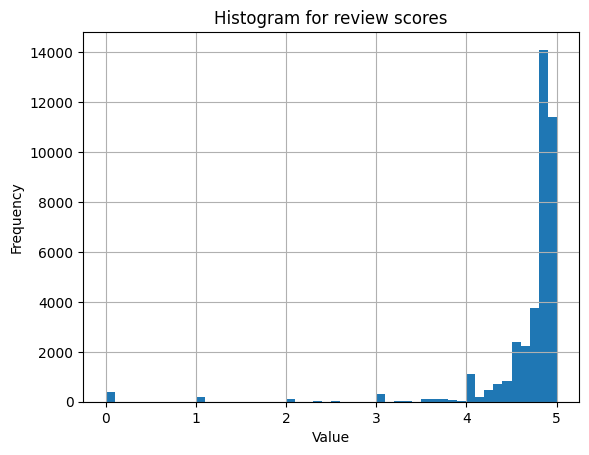

In [312]:
listings['review_scores_rating'].hist(bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram for review scores')
plt.show()


It is very skewed, so we should use the median. We also create a column which indicates whether or not the value needed to be imputed (1 for NaN and 0 for not NaN prior to imputation)

In [304]:
listings['imputed_review_score'] = listings['review_scores_rating'].isna().astype(int)

listings[["review_scores_rating", "imputed_review_score"]].head()


,review_scores_rating,imputed_review_score
0,4.80,0
1,NaN,1
2,NaN,1
3,5.00,0
4,4.98,0


In [305]:
median_value = listings['review_scores_rating'].median()
listings['review_scores_rating'].fillna(median_value, inplace=True)

In [306]:
# Checking for outliers

# Compute the sum of the three specified columns
sum_of_columns = (listings['calculated_host_listings_count_entire_homes'] + 
                 listings['calculated_host_listings_count_private_rooms'] + 
                 listings['calculated_host_listings_count_shared_rooms'])

# Create a boolean Series where True indicates the condition is not met
condition_not_met = ~(listings['calculated_host_listings_count'] >= sum_of_columns)

# Check how many rows don't satisfy the original condition
count_rows_not_met = condition_not_met.sum()

print(f"Number of rows where the condition is not met: {count_rows_not_met}")

Number of rows where the condition is not met: 0


### reviews_per_month

###### reviews_per_month has many NaN-values.

In [307]:
# Create boolean masks for NaN values in both columns
first_review_na = listings['first_review'].isna()
reviews_per_month_na = listings['reviews_per_month'].isna()

# Combine masks using XOR to find rows where only one column is NaN
only_one_na = first_review_na ^ reviews_per_month_na

# Count rows where only one of the columns is NaN
only_one_na_count = only_one_na.sum()

print(f"Number of rows where only one of 'first_review' or 'reviews_per_month' is NaN: {only_one_na_count}")

# The columns have the same NaN-values

Number of rows where only one of 'first_review' or 'reviews_per_month' is NaN: 0


In [308]:
# Replace NaN values with 0. The listing does not have any reviews yet.
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

### NaN-values

In [309]:
# Get the missing data counts
missing_data = listings.isna().sum()

# Convert the missing_data Series to a DataFrame for formatting
missing_data_df = missing_data.reset_index()
missing_data_df.columns = ['Column', 'Missing Count']

# Print the missing data counts as a nicely formatted table
print(tabulate(missing_data_df, headers='keys', tablefmt='pretty'))

+-----+----------------------------------------------+---------------+
|     |                    Column                    | Missing Count |
+-----+----------------------------------------------+---------------+
|  0  |                      id                      |       0       |
|  1  |                     name                     |       0       |
|  2  |                   host_id                    |       0       |
|  3  |                  host_since                  |       0       |
|  4  |              host_is_superhost               |       0       |
|  5  |             host_listings_count              |       0       |
|  6  |          host_total_listings_count           |       0       |
|  7  |             host_has_profile_pic             |       0       |
|  8  |            host_identity_verified            |       0       |
|  9  |            neighbourhood_cleansed            |       0       |
| 10  |         neighbourhood_group_cleansed         |       0       |
| 11  

In [311]:
# Calculate the percentage of NaN values in each column
nan_percentage = (listings.isna().mean() * 100).round(2)

# Convert the nan_percentage Series to a DataFrame for formatting
nan_percentage_df = nan_percentage.reset_index()
nan_percentage_df.columns = ['Column', 'NaN Percentage']

# Print the nan_percentage as a nicely formatted table
print(tabulate(nan_percentage_df, headers='keys', tablefmt='pretty'))

+-----+----------------------------------------------+----------------+
|     |                    Column                    | NaN Percentage |
+-----+----------------------------------------------+----------------+
|  0  |                      id                      |      0.0       |
|  1  |                     name                     |      0.0       |
|  2  |                   host_id                    |      0.0       |
|  3  |                  host_since                  |      0.0       |
|  4  |              host_is_superhost               |      0.0       |
|  5  |             host_listings_count              |      0.0       |
|  6  |          host_total_listings_count           |      0.0       |
|  7  |             host_has_profile_pic             |      0.0       |
|  8  |            host_identity_verified            |      0.0       |
|  9  |            neighbourhood_cleansed            |      0.0       |
| 10  |         neighbourhood_group_cleansed         |      0.0 